# WSI - Ćwiczenie 5

*Autor: Maksymilian Nowak*

### Cel ćwiczenia

Celem ćwiczenia jest zaimplementowanie algorytmu Q-learning z $\varepsilon$-zachłanną strategią losowania akcji. Algorytm należy zastosować do wytrenowania agenta rozwiązującego problemu *Cliff Walking* dostępnego w pakiecie `gymnasium`.

Należy zbadać wpływ współczynnika dyskontowania ($\lambda$) i szybkości uczenia ($\beta$) na działanie algorytmu.

## Implementacja algorytmu

In [1]:
import numpy as np

def q_learning(env, episodes, _lambda, beta, epsilon, t_max=150):
    '''
    :param env: środowisko
    :param episodes: liczba epizodów
    :param _lambda: współczynnik dyskontowania
    :param beta: współczynnik uczenia
    :param epsilon: współczynnik eksploracji
    '''
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    steps = []
    for _ in range(episodes):
        # Ocena strategii
        sum_reward = 0
        step = 0

        # Właściwy algorytm
        state = env.reset()[0]
        done = False
        t = 0
        while t < t_max and not done:
            # Epsilon-zachłanna strategia
            if np.random.uniform() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])
            next, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            sum_reward += reward
            step += 1
            Q[state][action] += beta * (reward + _lambda * np.max(Q[next]) - Q[state][action])
            state = next
            t += 1
        else:
            # Zapisanie wyników
            rewards.append(sum_reward)
            steps.append(step)

    return Q, rewards, steps


#### Inicjalizacja środowiska

Wyniki uczenia:
Minimalna nagroda: -546
Maksymalna nagroda: -13
Średnia nagroda: -58.89666666666667
Minimalna liczba kroków: 13
Maksymalna liczba kroków: 150
Średnia liczba kroków: 23.916666666666668


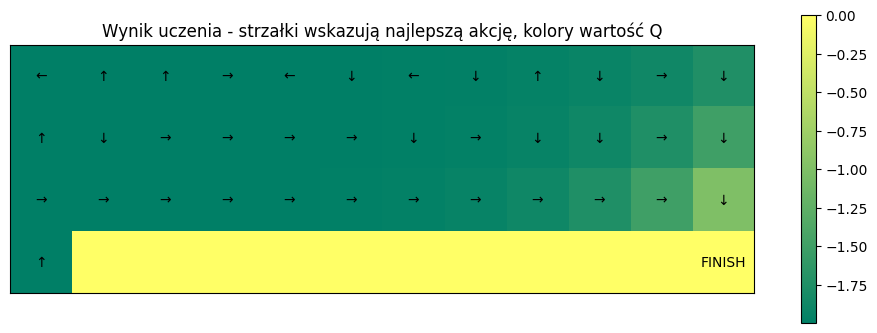

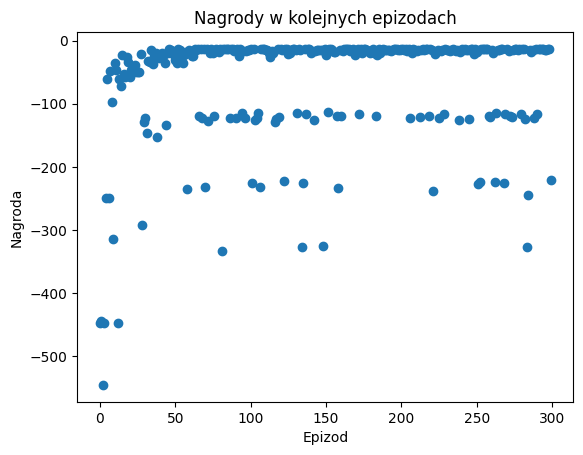

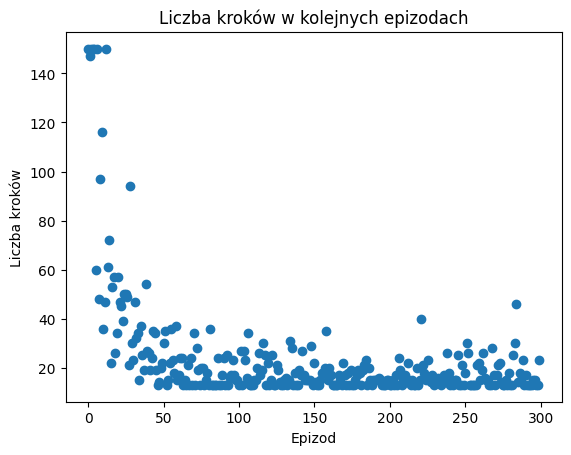

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt

env = gym.make('CliffWalking-v0')
Q, rewards, steps = q_learning(env, 300, 0.5, 0.5, 0.1)

def arrows(direction, value):
    if value.all() == 0:
        return ' '
    if direction == '0':
        return '↑'
    elif direction == '1':
        return '→'
    elif direction == '2':
        return '↓'
    elif direction == '3':
        return '←'

print('Wyniki uczenia:')
print(f'Minimalna nagroda: {np.min(rewards)}')
print(f'Maksymalna nagroda: {np.max(rewards)}')
print(f'Średnia nagroda: {np.mean(rewards)}')
print(f'Minimalna liczba kroków: {np.min(steps)}')
print(f'Maksymalna liczba kroków: {np.max(steps)}')
print(f'Średnia liczba kroków: {np.mean(steps)}')

heatmap = np.max(Q, axis=1).reshape((4, 12))
plt.figure(figsize=(12, 4))
plt.imshow(heatmap, cmap='summer', interpolation='nearest')
for y in range(4):
    for x in range(12):
        q_value = Q[y * 12 + x]
        plt.text(x, y, arrows(str(np.argmax(q_value)), q_value), color='black', ha='center', va='center')
plt.annotate('FINISH', xy=(11.5, 3.5), xytext=(11, 3), color='black', ha='center', va='center')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.title('Wynik uczenia - strzałki wskazują najlepszą akcję, kolory wartość Q')
plt.show()

plt.scatter(range(len(rewards)), rewards)
plt.xlabel('Epizod')
plt.ylabel('Nagroda')
plt.title('Nagrody w kolejnych epizodach')
plt.show()

plt.scatter(range(len(steps)), steps)
plt.xlabel('Epizod')
plt.ylabel('Liczba kroków')
plt.title('Liczba kroków w kolejnych epizodach')
plt.show()

## Badanie wpływu parametrów na działanie algorytmu

### Współczynnik dyskontowania

Lambda: 0.01, średnia nagroda: -164.6477, średnia liczba kroków: 145.5803
Lambda: 0.05, średnia nagroda: -122.28253333333333, średnia liczba kroków: 98.31133333333334
Lambda: 0.1, średnia nagroda: -69.0898, średnia liczba kroków: 28.8892
Lambda: 0.15, średnia nagroda: -66.86093333333334, średnia liczba kroków: 27.524933333333333
Lambda: 0.2, średnia nagroda: -65.5835, średnia liczba kroków: 26.6237
Lambda: 0.25, średnia nagroda: -64.6866, średnia liczba kroków: 25.9941
Lambda: 0.3, średnia nagroda: -63.33173333333333, średnia liczba kroków: 25.424633333333333
Lambda: 0.35, średnia nagroda: -62.7439, średnia liczba kroków: 25.0084
Lambda: 0.4, średnia nagroda: -62.458533333333335, średnia liczba kroków: 24.723033333333333
Lambda: 0.45, średnia nagroda: -61.54346666666667, średnia liczba kroków: 24.39206666666667
Lambda: 0.5, średnia nagroda: -61.201966666666664, średnia liczba kroków: 24.185866666666666
Lambda: 0.55, średnia nagroda: -61.1058, średnia liczba kroków: 23.9577
Lambda: 0.6,

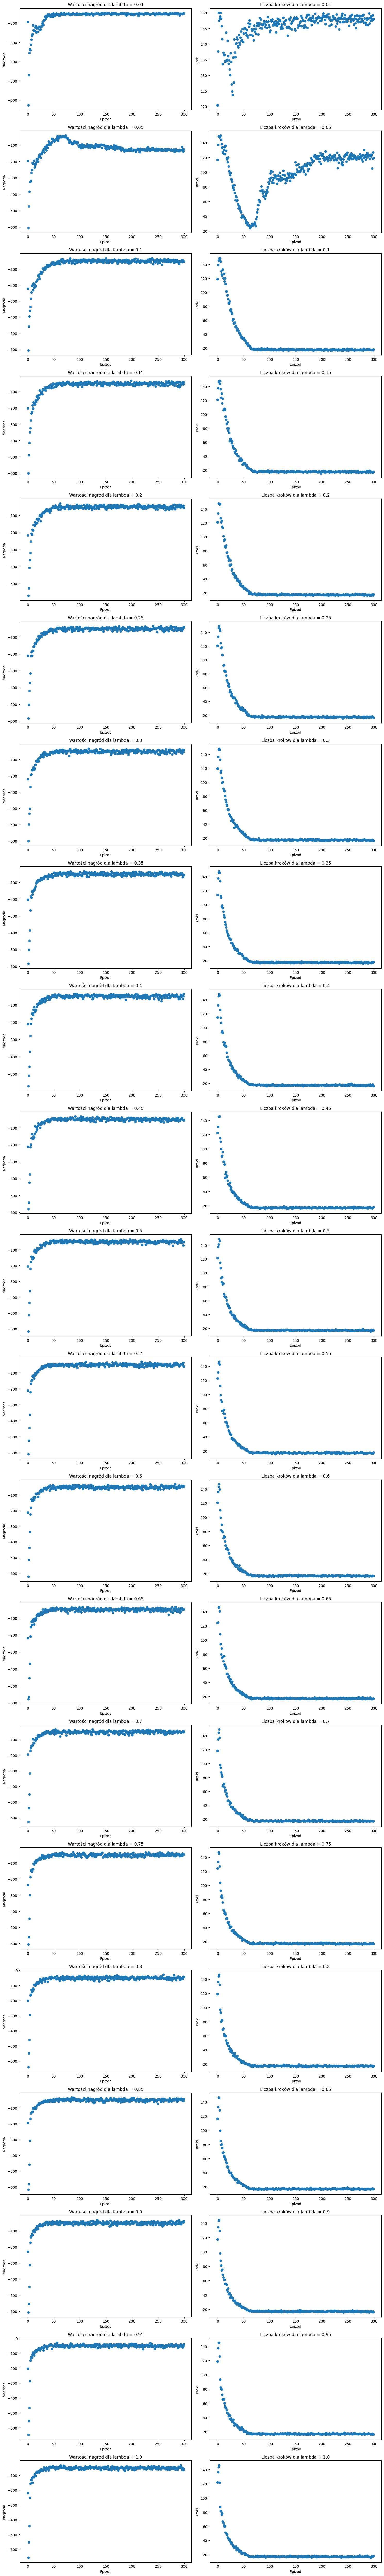

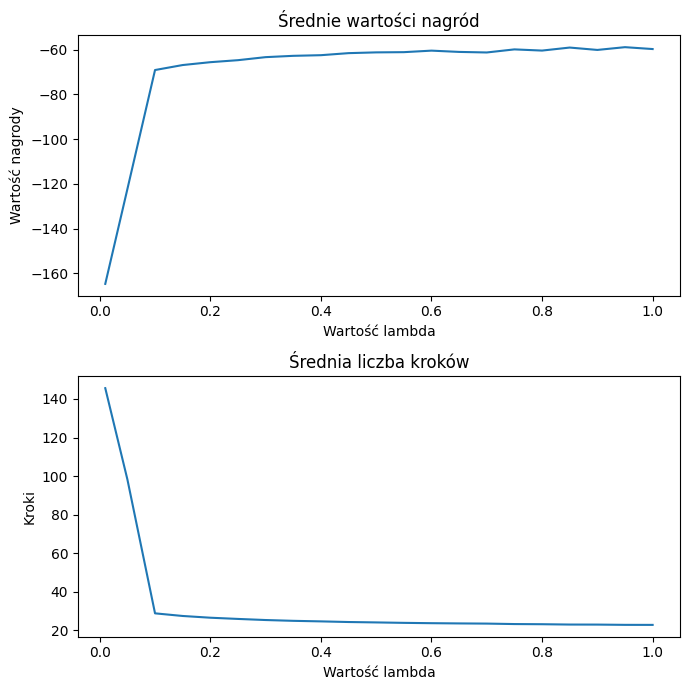

In [3]:
import matplotlib.pyplot as plt

def plot_lambda(values):
    rewards = []
    steps = []
    fig1, ax1 = plt.subplots(21, 2, figsize=(15, 100))
    for _lambda in values:
        lambda_rewards = []
        lambda_steps = []
        for _ in range(100):
            _, r, s = q_learning(env, 300, _lambda, 0.5, 0.1)
            lambda_rewards.append(r)
            lambda_steps.append(s)
        avg_episode_rewards = np.mean(lambda_rewards, axis=0)
        avg_episode_steps = np.mean(lambda_steps, axis=0)
        ax1[values.index(_lambda)][0].scatter(range(len(avg_episode_rewards)), avg_episode_rewards)
        ax1[values.index(_lambda)][0].set_xlabel('Epizod')
        ax1[values.index(_lambda)][0].set_ylabel('Nagroda')
        ax1[values.index(_lambda)][0].set_title(f'Wartości nagród dla lambda = {_lambda}')
        ax1[values.index(_lambda)][1].scatter(range(len(avg_episode_steps)), avg_episode_steps)
        ax1[values.index(_lambda)][1].set_xlabel('Epizod')
        ax1[values.index(_lambda)][1].set_ylabel('Kroki')
        ax1[values.index(_lambda)][1].set_title(f'Liczba kroków dla lambda = {_lambda}')
        avg_reward = np.mean(lambda_rewards)
        avg_steps = np.mean(lambda_steps)
        print(f'Lambda: {_lambda}, średnia nagroda: {avg_reward}, średnia liczba kroków: {avg_steps}')
        rewards.append(avg_reward)
        steps.append(avg_steps)
    fig1.tight_layout()
    fig2, ax2 = plt.subplots(2, figsize=(7, 7))
    ax2[0].plot(values, rewards)
    ax2[0].set_xlabel('Wartość lambda')
    ax2[0].set_ylabel('Wartość nagrody')
    ax2[0].set_title('Średnie wartości nagród')
    ax2[1].plot(values, steps)
    ax2[1].set_xlabel('Wartość lambda')
    ax2[1].set_ylabel('Kroki')
    ax2[1].set_title('Średnia liczba kroków')
    fig2.tight_layout()
    plt.show()

plot_lambda([0.01] + [round(0.05 * i, 2) for i in range(1, 21)])

### Współczynnik szybkości uczenia się

Beta: 0.01, średnia nagroda: -222.55866666666665, średnia liczba kroków: 132.01326666666668
Beta: 0.05, średnia nagroda: -138.14653333333334, średnia liczba kroków: 80.59453333333333
Beta: 0.1, średnia nagroda: -98.30096666666667, średnia liczba kroków: 54.00176666666667
Beta: 0.15, średnia nagroda: -82.89506666666666, średnia liczba kroków: 41.730866666666664
Beta: 0.2, średnia nagroda: -75.28586666666666, średnia liczba kroków: 35.547266666666665
Beta: 0.25, średnia nagroda: -70.37756666666667, średnia liczba kroków: 31.734566666666666
Beta: 0.3, średnia nagroda: -67.08276666666667, średnia liczba kroków: 29.21526666666667
Beta: 0.35, średnia nagroda: -65.39426666666667, średnia liczba kroków: 27.454166666666666
Beta: 0.4, średnia nagroda: -63.25386666666667, średnia liczba kroków: 26.043066666666668
Beta: 0.45, średnia nagroda: -62.34563333333333, średnia liczba kroków: 25.022633333333335
Beta: 0.5, średnia nagroda: -61.73546666666667, średnia liczba kroków: 24.207866666666668
Beta:

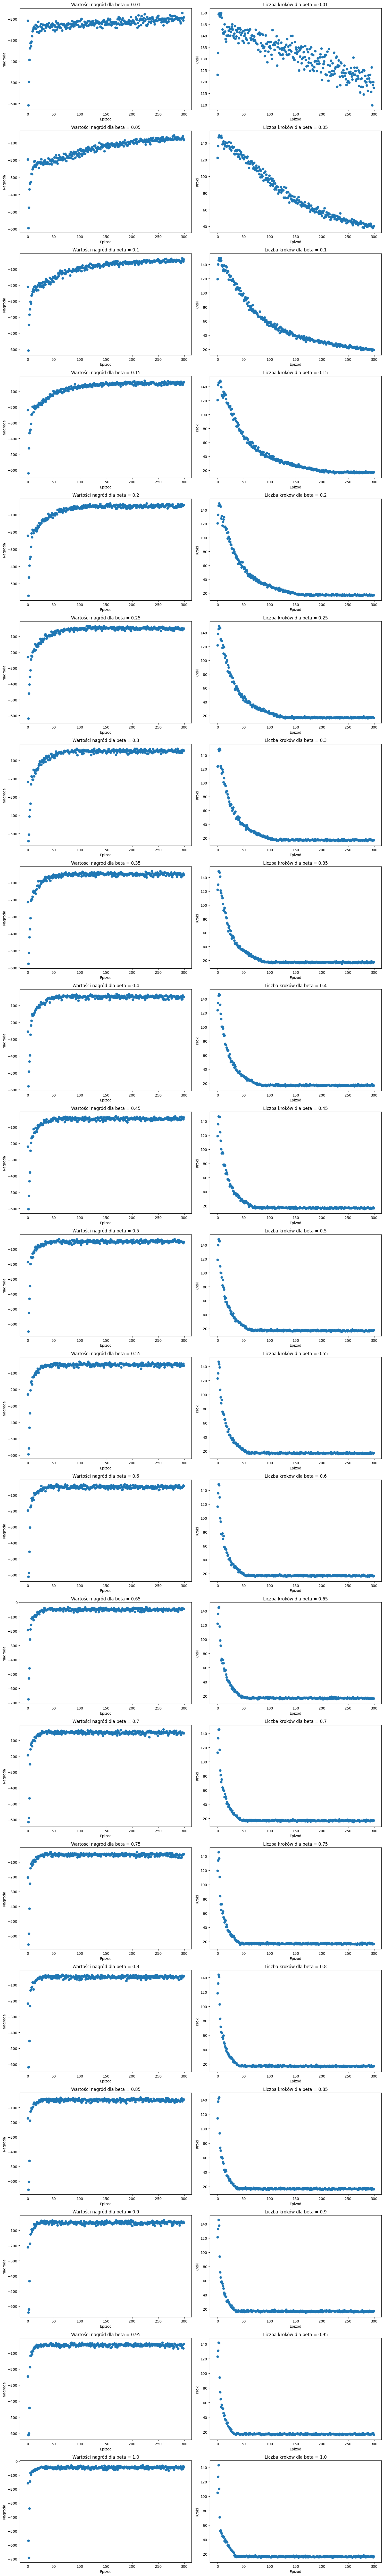

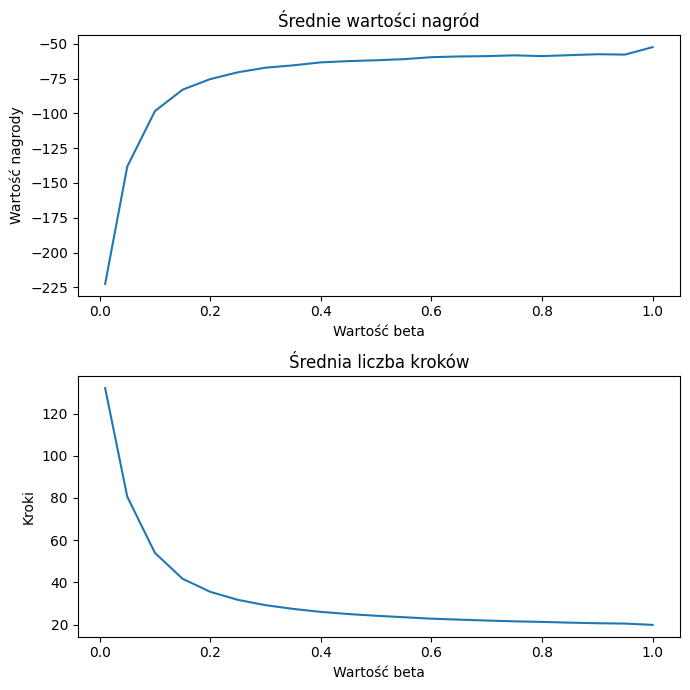

In [4]:
import matplotlib.pyplot as plt

def plot_beta(values):
    rewards = []
    steps = []
    fig1, ax1 = plt.subplots(21, 2, figsize=(15, 100))
    for beta in values:
        beta_rewards = []
        beta_steps = []
        for _ in range(100):
            _, r, s = q_learning(env, 300, 0.5, beta, 0.1)
            beta_rewards.append(r)
            beta_steps.append(s)
        avg_episode_rewards = np.mean(beta_rewards, axis=0)
        avg_episode_steps = np.mean(beta_steps, axis=0)
        ax1[values.index(beta)][0].scatter(range(len(avg_episode_rewards)), avg_episode_rewards)
        ax1[values.index(beta)][0].set_xlabel('Epizod')
        ax1[values.index(beta)][0].set_ylabel('Nagroda')
        ax1[values.index(beta)][0].set_title(f'Wartości nagród dla beta = {beta}')
        ax1[values.index(beta)][1].scatter(range(len(avg_episode_steps)), avg_episode_steps)
        ax1[values.index(beta)][1].set_xlabel('Epizod')
        ax1[values.index(beta)][1].set_ylabel('Kroki')
        ax1[values.index(beta)][1].set_title(f'Liczba kroków dla beta = {beta}')
        avg_reward = np.mean(beta_rewards)
        avg_steps = np.mean(beta_steps)
        print(f'Beta: {beta}, średnia nagroda: {avg_reward}, średnia liczba kroków: {avg_steps}')
        rewards.append(avg_reward)
        steps.append(avg_steps)
    fig1.tight_layout()
    fig2, ax2 = plt.subplots(2, figsize=(7, 7))
    ax2[0].plot(values, rewards)
    ax2[0].set_xlabel('Wartość beta')
    ax2[0].set_ylabel('Wartość nagrody')
    ax2[0].set_title('Średnie wartości nagród')
    ax2[1].plot(values, steps)
    ax2[1].set_xlabel('Wartość beta')
    ax2[1].set_ylabel('Kroki')
    ax2[1].set_title('Średnia liczba kroków')
    fig2.tight_layout()
    plt.show()

plot_beta([0.01] + [round(0.05 * i, 2) for i in range(1, 21)])